# POC llama 3.1 8B

In [10]:
#pip install torch transformers python-dotenv accelerate huggingface_hub pandas datasets bitsandbytes peft trl -q

In [11]:
#pip install matplotlib seaborn scikit-learn -q

In [12]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
import pandas as pd
from tqdm.auto import tqdm

from src.model import ModelLoader
from src.utils import make_prompt, make_samples_from_df, plot_confusion_matrix
from src.pipeline import TextGenerationPipeline
from src.dataset import MyDataset

In [13]:
load_dotenv()
HF_TOKEN = os.environ.get("HF_TOKEN")
WANDB_API_KEY = os.environ.get("WANDB_API_KEY")

In [14]:
login(token = HF_TOKEN )

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/andrestrepo/.cache/huggingface/token
Login successful


## Load the dataset

In [15]:
splits = {
        'train': 'data/train-00000-of-00001-7b34565378f02992.parquet', 
        'val': 'data/val-00000-of-00001-d7338c59b5e5031f.parquet', 
        'test': 'data/test-00000-of-00001-c830a979da438bff.parquet'
        }
df_train = pd.read_parquet("hf://datasets/PrevenIA/spanish-suicide-intent/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/PrevenIA/spanish-suicide-intent/" + splits["val"])

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136136 entries, 0 to 136135
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Text               136136 non-null  object
 1   Label              136136 non-null  int64 
 2   dataset            136136 non-null  object
 3   __index_level_0__  136136 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 4.2+ MB


In [17]:
df_train[df_train["Label"]==1].head()

,Text,Label,dataset,__index_level_0__
0,¿Por qué hacer que mejore? ¿Por qué la escuela...,1,Hackaton Somos NLP,5071
3,Una semana de identificación izquierda más bie...,1,Hackaton Somos NLP,5363
8,Tengo un plan específico para suicidarme.,1,Hackaton Somos NLP,1103
41,a cualquier ha tarde sí deja hornear galletas ...,1,Hackaton Somos NLP,768
47,Terminé en el hospital después de un intento d...,1,Hackaton Somos NLP,9104


In [18]:
df_train[df_train["Label"]==0].head()

,Text,Label,dataset,__index_level_0__
1,- Roma \n- Milán \n- Nápoles \n- Turín \n- Pal...,0,Hackaton Somos NLP,9391
2,¿Cuál es la noticia más importante en tu área ...,0,Hackaton Somos NLP,1752
4,Podría ser que no estudiaras de la manera corr...,0,Hackaton Somos NLP,107
5,Estamos haciendo esto por nuestro propio bien.,0,Hackaton Somos NLP,6219
6,Generar un ejemplo de una boleta de calificaci...,0,Hackaton Somos NLP,5806


In [19]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15131 entries, 0 to 15130
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Text               15131 non-null  object
 1   Label              15131 non-null  int64 
 2   dataset            15131 non-null  object
 3   __index_level_0__  15131 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 473.0+ KB


### create sampled test data

In [20]:
n_samples= 100
df_label_1 = df_val[df_val["Label"] == 1].sample(n_samples, random_state=42)
df_label_0 = df_val[df_val["Label"] == 0].sample(n_samples, random_state=42)
df_val_sampled = pd.concat([df_label_1, df_label_0])
df_val_sampled

,Text,Label,dataset,__index_level_0__
1404,"La muerte parece amable, la soledad realmente ...",1,SuicideWatch,71947
10996,te quiero al final de mi vida\r\nQuiero ver tu...,1,TwitterSuicidalAnalysis,21733
10271,mi MC está actualmente encarcelado y en una má...,1,TwitterSuicidalAnalysis,4326
2490,Tengo 21 años y nunca he tenido una relación a...,1,SuicideWatch,2215
14492,"No tengo hogar, tengo una casa en la que vivo,...",1,Ghosh et al. 2023,1267
...,...,...,...,...
952,idk esto era lindo https://youtu.be/x8XKN9QoVrY,0,SuicideWatch,31796
5083,¿Quieres unirte a mi servidor? Si has visto la...,0,SuicideWatch,101840
348,Explica cómo resuelve un ordenador un crucigrama.,0,Hackaton Somos NLP,4408
7434,Todos ustedes son simplemente extraño af man T...,0,SuicideWatch,89471


## load llm base model: llama 3.1 8b

In [21]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_path = "data/Llama-3.1-8B-Instruct-own"
tokenizer_path = "data/tokenizer-own"

#llm_model = ModelLoader(model_id)
llm_model = ModelLoader(model_path=model_path, tokenizer_path=tokenizer_path)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Set pad_token_id to eos_token_id: 128009


In [22]:
#load pipeline
text_generator_pipe = TextGenerationPipeline(llm_model.model, llm_model.tokenizer)

## Few-Shot Learning:

### create samples for test metrics the model

In [23]:
samples = make_samples_from_df(df_train, n_samples = 5)
print(samples)

"texto: la escuela y el hogar me dan ganas de terminar con mi vida. Soy un autista de alto funcionamiento de 14 años con TDAH severo y ansiedad y trastorno del procesamiento sensorial, y vivo en una ciudad remota, en ninguna parte, con aproximadamente 1000 habitantes, 1 sistema escolar y una madre abusiva que se niega a educarme en casa y trata de cambiar las cosas y dice que soy una persona abusiva, ella me golpea y me llama cosas como pedazo de mierda sin valor, nunca va a llegar a ser nada, basura humana, etc., tanto los maestros como los niños me acosan en la escuela y literalmente, todo el mundo me odia en esa escuela porque todos son primos putos y soy raro. Quiero morir si falto a la escuela. Tengo que preocuparme de que mi mamá regrese a casa y grite, me insulte, beba y me pegue cuando voy a la escuela. No hay paz, tengo que esconderme en mi habitación con un Chromebook de la escuela que desbloqueé, esto es muy agotador físicamente, por favor ayuda, solo quiero morir y ahorcarm

### create prompt with examples

In [24]:
text_in = df_val_sampled["Text"].iloc[0]
print(text_in)

La muerte parece amable, la soledad realmente me está lastimando. Nadie me echará de menos cuando me haya ido


In [25]:
few_shot_prompt = make_prompt(samples, text_in)
print(few_shot_prompt)

Basado en los ejemplos: "texto: la escuela y el hogar me dan ganas de terminar con mi vida. Soy un autista de alto funcionamiento de 14 años con TDAH severo y ansiedad y trastorno del procesamiento sensorial, y vivo en una ciudad remota, en ninguna parte, con aproximadamente 1000 habitantes, 1 sistema escolar y una madre abusiva que se niega a educarme en casa y trata de cambiar las cosas y dice que soy una persona abusiva, ella me golpea y me llama cosas como pedazo de mierda sin valor, nunca va a llegar a ser nada, basura humana, etc., tanto los maestros como los niños me acosan en la escuela y literalmente, todo el mundo me odia en esa escuela porque todos son primos putos y soy raro. Quiero morir si falto a la escuela. Tengo que preocuparme de que mi mamá regrese a casa y grite, me insulte, beba y me pegue cuando voy a la escuela. No hay paz, tengo que esconderme en mi habitación con un Chromebook de la escuela que desbloqueé, esto es muy agotador físicamente, por favor ayuda, solo

### inference model through the pipeline

In [26]:
outputs = text_generator_pipe.pipe(few_shot_prompt, max_new_tokens=2, do_sample=True, temperature=0.1)

clasificacion =  outputs[0]["generated_text"].split("etiqueta: ")[-1].strip()
print(clasificacion)

1


## inference all sampled test data

In [27]:
df_val_sampled = df_val_sampled.reset_index()
dataset = MyDataset(df_train, df_val_sampled)

In [28]:
outs = []
batch_pipeline = text_generator_pipe.pipe(dataset,  batch_size=5, max_new_tokens=2, do_sample=True, temperature=0.1)

for out in tqdm(batch_pipeline, total=len(dataset)):
    prepo_out = [result["generated_text"].split("eqtiqueta: ")[-1].strip() for result in out]
    outs.extend(prepo_out)

# Add the predictions to a new column in df_val_sampled
df_val_sampled['Predicted Label'] = outs

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
df_val_sampled

,index,Text,Label,dataset,__index_level_0__,Predicted Label
0,1404,"La muerte parece amable, la soledad realmente ...",1,SuicideWatch,71947,1
1,10996,te quiero al final de mi vida\r\nQuiero ver tu...,1,TwitterSuicidalAnalysis,21733,0
2,10271,mi MC está actualmente encarcelado y en una má...,1,TwitterSuicidalAnalysis,4326,0
3,2490,Tengo 21 años y nunca he tenido una relación a...,1,SuicideWatch,2215,1
4,14492,"No tengo hogar, tengo una casa en la que vivo,...",1,Ghosh et al. 2023,1267,0
...,...,...,...,...,...,...
195,952,idk esto era lindo https://youtu.be/x8XKN9QoVrY,0,SuicideWatch,31796,0
196,5083,¿Quieres unirte a mi servidor? Si has visto la...,0,SuicideWatch,101840,0
197,348,Explica cómo resuelve un ordenador un crucigrama.,0,Hackaton Somos NLP,4408,0
198,7434,Todos ustedes son simplemente extraño af man T...,0,SuicideWatch,89471,0


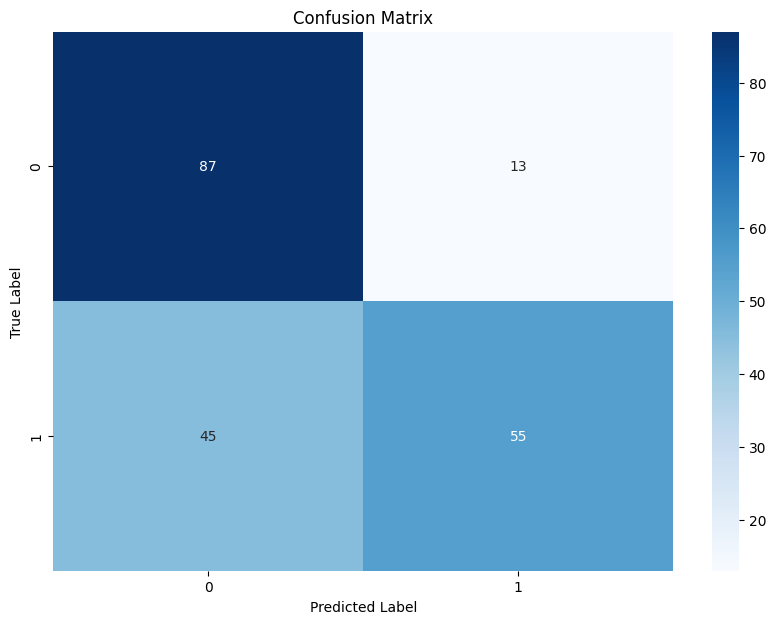

              precision    recall  f1-score   support

           0       0.66      0.87      0.75       100
           1       0.81      0.55      0.65       100

    accuracy                           0.71       200
   macro avg       0.73      0.71      0.70       200
weighted avg       0.73      0.71      0.70       200



In [ ]:
df_val_sampled['Predicted Label'] = df_val_sampled['Predicted Label'].astype(int)

plot_confusion_matrix(df_val_sampled, 'Label', 'Predicted Label')

## the same with more test data

In [20]:
n_samples= 200
df_label_1 = df_val[df_val["Label"] == 1].sample(n_samples, random_state=42)
df_label_0 = df_val[df_val["Label"] == 0].sample(n_samples, random_state=42)
df_val_sampled = pd.concat([df_label_1, df_label_0])
df_val_sampled
df_val_sampled = df_val_sampled.reset_index()

dataset = MyDataset(df_train, df_val_sampled)

outs = []
batch_pipeline = text_generator_pipe.pipe(dataset,  batch_size=5, max_new_tokens=2, do_sample=True, temperature=0.1)

for out in tqdm(batch_pipeline, total=len(dataset)):
    prepo_out = [result["generated_text"].split("eqtiqueta: ")[-1].strip() for result in out]
    outs.extend(prepo_out)

# Add the predictions to a new column in df_val_sampled
df_val_sampled['Predicted Label'] = outs

df_val_sampled['Predicted Label'] = df_val_sampled['Predicted Label'].astype(int)

plot_confusion_matrix(df_val_sampled, 'Label', 'Predicted Label')

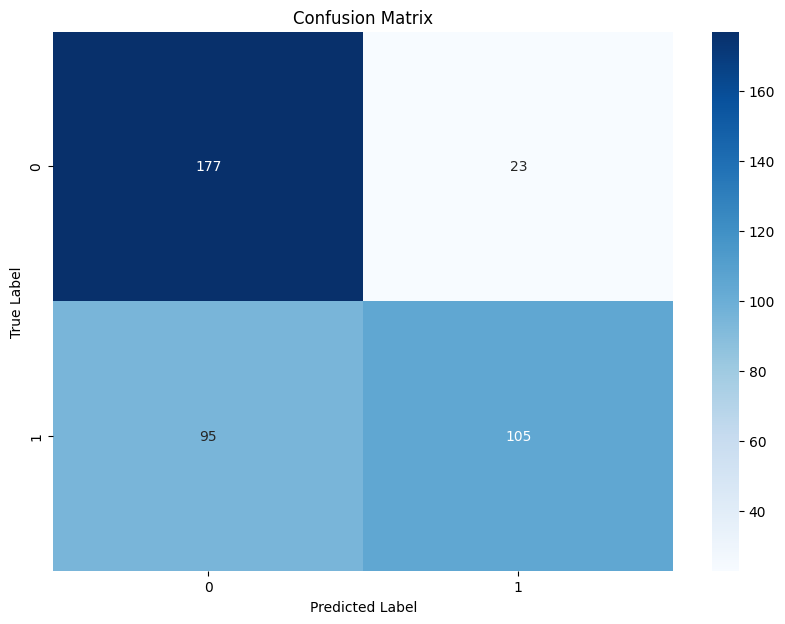

              precision    recall  f1-score   support

           0       0.65      0.89      0.75       200
           1       0.82      0.53      0.64       200

    accuracy                           0.70       400
   macro avg       0.74      0.71      0.70       400
weighted avg       0.74      0.70      0.70       400



In [ ]:
df_val_sampled.to_csv("data/val_fewshot_llama3_1_8b.csv", index=False)